<div dir=rtl>
    <h2>
        سوال سوم پروژه - سینا باقری نژاد
    </h2>
    </div>

<div dir=rtl>
    ابتدا کتابخوانه های مورد نظر را فراخوانی می کنیم.
    </div>

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools

<div dir=rtl>
    به منظور نمایش خروجیها در آینده، تابعی را تعریف می کنیم
    </div>

In [44]:
def showImage(img):
    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.show()
    
def showImages(img1, img2):
    plt.figure(figsize=(18, 10))
    plt.subplot(1,2,1); plt.imshow(img1)
    plt.subplot(1,2,2); plt.imshow(img2)
    plt.show()

<div dir=rtl>
   فایل ویدیویی را باز کرده و اولین فریم آن را میخوانیم. نقاط مربوط به محدوده ای که میخواهیم با آن کار کنیم را نیز مشخص می کنیم. در واقع میخواهیم تصویری دیگر را همواره به طوری بر روی این صفحه شطرنجی قرار دهیم که چهار گوشه آن بر این چهار نقطه منطبق باشد.
    </div>

In [45]:
capture = cv2.VideoCapture('videos/video1.avi')
_, frame = capture.read()
init_points = np.array([[188, 228],
                        [174, 956],
                        [636, 978],
                        [657, 231]
                       ])

<div dir=rtl>
    حال لازم است ناحیه ای که با این چهار نقطه مشخص میشود را تعیین کنیم. زیرا بعدا فقط ویژگیهای این ناحیه را تعیین و بررسی خواهیم کرد و حرکت آن را مورد بررسی قرار خواهیم داد.
    </div>

In [68]:
def to_homogeneous(point):
    return np.append(point, 1)

def to_cartesian(point):
    return np.delete(point / point[-1], -1)

def to_homogeneous_points(points):
    return np.append(points, np.ones([points.shape[0], 1]), axis=1)

def to_cartesian_points(points):
    return np.delete(points / points[:,-1].reshape(-1,1), -1, axis=1)

def get_area(image, points):
    mask = np.zeros_like(image[:,:,1], dtype=bool)
    h_points = to_homogeneous_points(points)
    lines = np.array([np.cross(h_points[0], h_points[1]),
                      np.cross(h_points[1], h_points[2]),
                      np.cross(h_points[2], h_points[3]),
                      np.cross(h_points[3], h_points[0])])
    x = np.arange(0, image.shape[0], 1)
    y = np.arange(0, image.shape[1], 1)
    inter_points = list(itertools.product(x, y))
    check_lines = np.all(lines @ to_homogeneous_points(np.array(inter_points)).T < 0, axis = 0)
    for idx, point in enumerate(inter_points):
        mask[point] = check_lines[idx]
    return mask.astype(np.uint8)

mask = get_area(frame, init_points)

<div dir=rtl>
    ناحیه بدست آمده و نقاط مربوطه را در تصویر زیر میبینید. چهار نقطه قرمز در واقع چهار گوشه تصویر خواهند بود و بخش زرد رنگ بخشی است که ما با ویژگی های آن کار خواهیم داشت.
    </div>

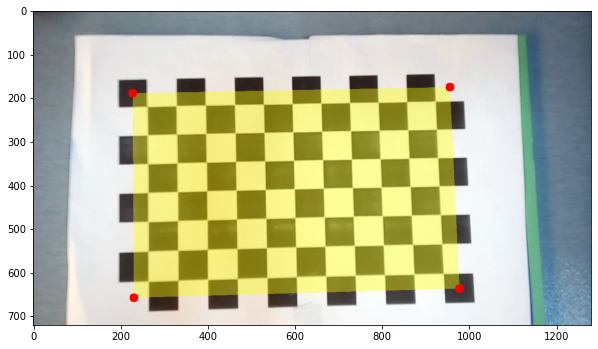

In [47]:
vis = frame.copy()
vis[np.nonzero(mask)] = [255, 255, 0]
vis = cv2.addWeighted(frame, 0.6, vis, 0.4, 0.0)
for p in init_points:
    x,y = p.ravel()
    vis = cv2.circle(vis,(y, x),10,[250,0,0],-1)

showImage(vis)

<div dir=rtl>
    حال نقاط ویژگی harris را محاسبه و نمایش میدهیم. همانطور که ذکر شد این نقاط فقط برای محدوده ای که با رنگ زرد نمایش داده شده اند محاسبه می شود و کاری به لبه ها و گوشه ها در خارج از این محدوده نداریم.
    </div>

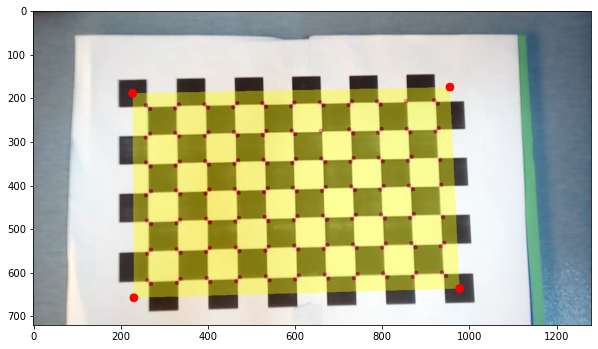

In [69]:
def harrisCorner(img, mask):
    feature_params = dict( maxCorners = 0,
                       qualityLevel = 0.03,
                       minDistance = 10,
                       useHarrisDetector=True,
                       blockSize = 10,
                       k = 0
                     )
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, mask=mask, **feature_params)
    return corners

def showCorners(image, corners):
    img = image.copy()
    corners = np.int0(corners)
    for i in corners:
        x,y = i.ravel()
        cv2.circle(img,(x,y),5,255,-1)
    return img


corners = harrisCorner(frame, mask)

vis = frame.copy()
vis[np.nonzero(mask)] = [255, 255, 0]
vis = showCorners(vis, corners)
vis = cv2.addWeighted(frame, 0.6, vis, 0.4, 0.0)
for p in init_points:
    x,y = p.ravel()
    vis = cv2.circle(vis,(y, x),10,[250,0,0],-1)

showImage(vis)

<div dir=rtl>
    در ادامه توابعی که در تمرین اول و دوم پیاده کرده بودیم آمده اند. ما در این تمرین میخواهیم ابتدا یک ماتریس هموگرافی برای انطباق تصویر مورد نظر و این چهار نقطه تعیین شده در تصویر شطرنجی بیابیم و آن تصویر را بر صفحه شطرنج منطبق کنیم و در ادامه فریم به فریم حرکت این چهار نقطه را دنبال کنیم و تصویر را بر روی آن بیندازیم. به همین منظور لازم است از همان توابعی که در تمرین اول و دوم استفاده شده است، استفاده کنیم.
    </div>

In [62]:
def get_random_points(points_1, points_2, k=4):
    indices = random.sample(list(range(len(points_1))), k)
    return points_1[indices], points_2[indices]

def homography(p1, p2):
    A = np.zeros((len(p1) * 2, 9))
    for i in range(len(p1)):
        x1, y1 = p1[i, 0], p1[i, 1]
        x2, y2 = p2[i, 0], p2[i, 1]
        A[2*i] = [-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2]
        A[2*i+1] = [0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2]
    u, s, vh = np.linalg.svd(A)
    h = vh[8].reshape(3, 3)
    return h


image = cv2.imread('images/room.jpg')

image_points = np.array([[0, 0],
                         [0, image.shape[1]-1],
                         [image.shape[0]-1, image.shape[1]-1],
                         [image.shape[0]-1, 0],
                        ])
h = homography(image_points, init_points)

<div dir=rtl>
    در این تمرین از همان تصویر اتاق که در تمرین دوم استفاده کردیم برای انطباق بر صفحه شطرنجی استفاده می کنیم. تصویر زیر در واقع خروجی ما برای فریم اول است. حالا باید با جلو رفتن فیلم و به صورت فریم به فریم، این تصویر را بر روی صفحه شطرنجی بیاندازیم.
    </div>

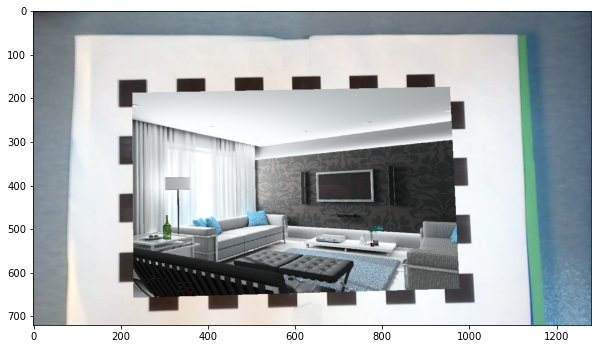

In [63]:
def warp_perspective(image, h, shape):
    new_image = np.uint8(np.zeros(shape))
    i = np.arange(0, image.shape[0], 1)
    j = np.arange(0, image.shape[1], 1)
    x = list(itertools.product(i, j))
    x_prime = np.array(to_cartesian_points((h @ to_homogeneous_points(np.array(x)).T).T), dtype='int0')
    x_prime = list(map(tuple, x_prime))
    for idx, point in enumerate(x_prime):
        new_image[point] = image[x[idx]]
    return new_image

def augmented_reality(image, h, frame):
    new_image = warp_perspective(image, h, shape=frame.shape)
    cp_frame = frame.copy()
    cp_frame[new_image.nonzero()] = 0
    return new_image + cp_frame

showImage(augmented_reality(image, h, frame))

In [94]:
lk_params = dict(winSize  = (10, 10),
                     maxLevel = 7,
                     criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
                    )
def lk_tracker(img1, img2, keypoints, lk_params = lk_params):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    p0 = keypoints
    mask = np.zeros_like(img1)
    color = np.random.randint(0,255,(100,3))
    p1, st, err = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None, **lk_params)
    if p1 is not None:
        good_points_1 = p0[st==1]
        good_points_2 = p1[st==1]
    return good_points_1, good_points_2

In [65]:
def n_iteration(p, e, s=4):
    return round(np.log(1-p)/np.log(1-(1-e)**s))

def get_votes(good_points_1, good_points_2, h, threshold):
    points_prime = to_cartesian_points((h @ to_homogeneous_points(good_points_1).T).T)
    votes = np.linalg.norm(points_prime - good_points_2, axis=1) < threshold
    count_votes = votes.sum()
    voters = (good_points_1[votes], good_points_2[votes])
    return count_votes, voters

def ransac(good_points_1, good_points_2, iterations, threshold=2):
    best_h = np.zeros((3, 3))
    best_votes = 0
    best_voters = (0, 0)
    for _ in range(iterations):
        p1, p2 = get_random_points(good_points_1, good_points_2)
        h = homography(p1, p2)
        votes, voters = get_votes(good_points_1, good_points_2, h, threshold)
        if votes > best_votes:
            best_votes = votes
            best_h = h
            best_voters = voters
    return best_h, best_votes, best_voters

<div dir=rtl>
    با توجه به آنچه گفته شد میخواهیم محل ۴ نقطه تعیین شده را فریم به فریم و با استفاده از ردگیری از طریق روش Lucas-Kanade بر روی ویژگیهای Harris استخراج شده به ماتریس هموگرافی برسیم و این نقاط را با استفاده از ماتریس هموگرافی حاصل فریم به فریم تعیین و نمایش دهیم.
    </div>

<div dir=rtl>
    بدین منظور تقریبا آنچه در تمرین اول انجام شده را پی گرفته ایم و نتایج را برای ۱۰ فریم اولیه در ادامه مشاهده می کنید. 
    </div>

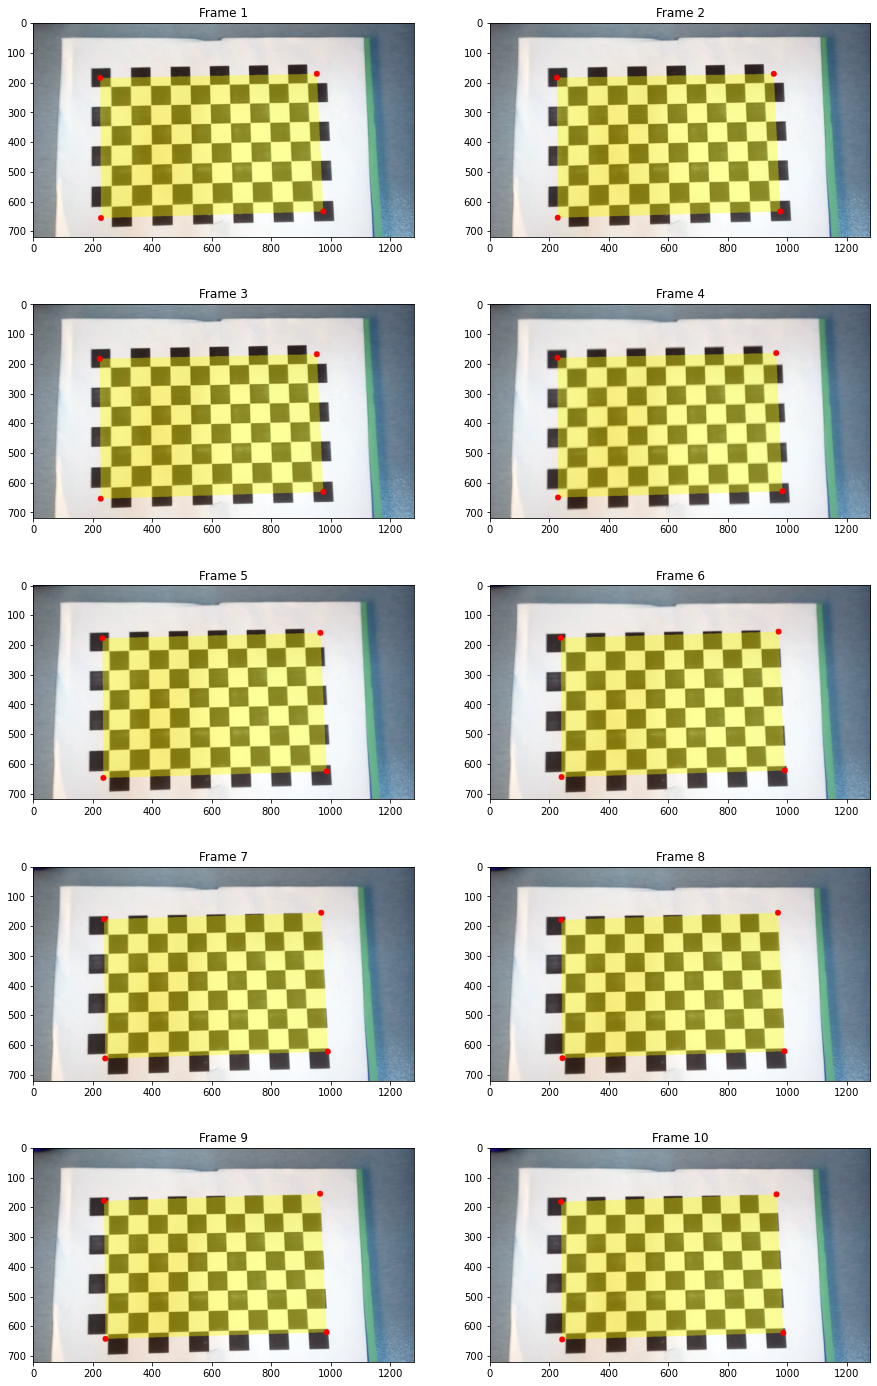

In [35]:
capture = cv2.VideoCapture('videos/video1.avi')
_, first_frame = capture.read()
init_points = np.array([[188, 228],
                        [174, 956],
                        [636, 978],
                        [657, 231]
                       ])

h = np.identity(3)

p = 0.99
e = 0.9
iterations = n_iteration(p, e)

old = first_frame.copy()
points = init_points.copy()

plt.figure(figsize=(15, 25))
for i in range(10):
    # read new frame
    _, new = capture.read()
    
    # herris features of old frame
    mask = get_area(old, points)
    corners = harrisCorner(old, mask)

    # track features of old frame
    good_points_1, good_points_2 = lk_tracker(old, new, corners)
    h_new, v, bv = ransac(good_points_1, good_points_2, iterations, threshold=0.5)
    
    h = h_new @ h
    points = np.int0(to_cartesian_points((h @ to_homogeneous_points(init_points).T).T))
    mask = get_area(new, points)
    
    vis = new.copy()

    vis[np.nonzero(mask)] = [255, 255, 0]
    vis = cv2.addWeighted(new, 0.6, vis, 0.4, 0.0)

    for p in np.int0(points):
        x,y = p.ravel()
        vis = cv2.circle(vis,(y, x),10,[250,0,0],-1)

    plt.subplot(5,2,i+1).set_title('Frame {}' .format(i+1))
    plt.imshow(vis)

    old = new.copy()
plt.show()

<div dir=rtl>
    همانطور که در این ۱۰ فریم دیدیم، این روش به دلیل اینکه هر بار محاسبه ماتریس هموگرافی دارای خطای کوچکی است، نقاط از محل خود کمی جا به جا می شوند. و چون هیچ مکانیزیم اصلاحی برای بازگرداندن این نقاط به محل اصلی خود وجود ندارد، بعد از چندین فریم کاملا به جای نادرستی خواهند رفت که اصلا مطلوب ما نیست. در ویدیو زیر میتوانید این خروجی را مشاهده کنید. بعد از چندین فریم، ناحیه مورد بررسی از صفحه خارج شده و به بیرون کشیده می شود و در نهایت از بین میرود.
    </div>

<video width="320" height="240" controls>
  <source src="videos/result_1.avi" type="video/mp4">
</video>

<div dir=rtl>
    اینبار روشی دیگر را پیش گرفتیم. در این روش علاوه بر اینکه نقاط ویژگی در فریمهای متوالی ردگیری میشوند، نقاط ویژگی در فریم اول نیز در تمام فریمها ردگیری می شود. اگر تعداد رای هایی که نقاط ویژگی فریم اول به ماتریس هموگرافی میدهند، بیشتر از تعداد رایهای نفاط ویژگی در فریمهای متوالی باشد، ماتریس هموگرافی ای که از ویژگیهای فریم اول محاسبه شده است برای آن فریم در نظر گرفته می شود. منطق این ایده این است که چون نقاط اولیه و ناحیه در فریم اول به درستی قرار دارد، هنگامی که ناحیه مورد بررسی مثل ویدیو قبل از از مسیر اصلی خارج می شود، نقاط ویژگی کمتری را پیدا خواهد کرد( چون در صفحه شطرنجی نقاط ویژگی Harris بیشتری وجود دارد.) لذا ناحیه ای که توسط ویژگیهای فریم اول پیدا میشود، احتمالا بهتر خواهند بود.
    </div>

In [90]:
capture = cv2.VideoCapture('videos/video1.avi')
ret, first_frame = capture.read()
init_points = np.array([[188, 228],
                        [174, 956],
                        [636, 978],
                        [657, 231]
                       ])
init_mask = get_area(first_frame, init_points)
init_corners = harrisCorner(first_frame, init_mask)

h = np.identity(3)

p = 0.99
e = 0.4
iterations = n_iteration(p, e)

old = first_frame.copy()
points = init_points.copy()

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
writer = cv2.VideoWriter('videos/result.mp4', fourcc, 15, (first_frame.shape[1], first_frame.shape[0]))

# while True:
for i in range(100):
    # read new frame
    ret, new = capture.read()
    if not ret:
        break
    
    # herris features of old frame
    mask = get_area(old, points)
    corners = harrisCorner(old, mask)
    try:
        # track features of old frame
        good_points_1, good_points_2 = lk_tracker(old, new, corners)
        h_new1, v1, bv1 = ransac(good_points_1, good_points_2, iterations, threshold=0.5)
    except:
        v1 = 0
        h_new1 = np.identity(3)
    # track features of init frame
    good_points_1, good_points_2 = lk_tracker(first_frame, new, init_corners)
    h_new2, v2, bv2 = ransac(good_points_1, good_points_2, iterations, threshold=0.5)
    
    if v2 > v1:
        h = h_new2.copy()
    else:
        h = h_new1 @ h
    
    points = np.int0(to_cartesian_points((h @ to_homogeneous_points(init_points).T).T))
    mask = get_area(new, points)

    vis = new.copy()

    vis[np.nonzero(mask)] = [255, 255, 0]
    vis = cv2.addWeighted(new, 0.6, vis, 0.4, 0.0)

    for p in np.int0(points):
        x,y = p.ravel()
        vis = cv2.circle(vis,(y, x),10,[250,0,0],-1)
    
    writer.write(vis)
    old = new.copy()
writer.release()